# Step 3: Pre-processing and Training Data Development

### Load Data and Import Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve


In [3]:
# Import clean data
datapath = '/Users/kbrewitt/Github/Predicting Longevity Using Urban Greenspace/clean_data/London_data_cleaned.csv'
df = pd.read_csv(datapath, index_col=0)


In [4]:
# Check imported data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   New ward code                3275 non-null   object 
 1   Ward                         3275 non-null   object 
 2   Borough                      3275 non-null   object 
 3   Year                         3275 non-null   int64  
 4   Life_Expectancy              3275 non-null   float64
 5   Childhood_Obesity            3275 non-null   float64
 6   Incapacity_Benefit           3275 non-null   float64
 7   Unemployment                 3275 non-null   float64
 8   Crime                        3275 non-null   float64
 9   Deliberate_Fires             3275 non-null   float64
 10  GCSE_points                  3275 non-null   float64
 11  Unauthorised_School_Absence  3275 non-null   float64
 12  Dependent_children           3275 non-null   float64
 13  Public_Transport_A

,New ward code,Ward,Borough,Year,Life_Expectancy,Childhood_Obesity,Incapacity_Benefit,Unemployment,Crime,Deliberate_Fires,GCSE_points,Unauthorised_School_Absence,Dependent_children,Public_Transport_Access,Greespace_Access,Borough Green Space Surface
0,E09000001,City of London,City of London,2009,84.329356,22.220000,3.333333,2.999195,18.389167,0.684932,346.80,0.24,17.14,7.723401,-6.478752,4.8
1,E05000026,Abbey,Barking and Dagenham,2009,82.076112,21.700880,4.586610,8.325803,180.721564,1.908646,311.29,1.22,37.71,5.987356,-0.889538,33.6
2,E05000027,Alibon,Barking and Dagenham,2009,77.828392,25.974026,7.033561,9.857754,125.168618,1.099268,302.16,1.53,40.00,3.275530,-1.790968,33.6
3,E05000028,Becontree,Barking and Dagenham,2009,78.430683,22.448980,6.734643,9.405173,149.022537,0.967892,320.30,1.55,37.59,2.848544,-5.469666,33.6
4,E05000029,Chadwell Heath,Barking and Dagenham,2009,79.887841,23.795181,6.675432,8.567379,135.434080,1.850122,324.70,1.22,39.66,2.272302,1.977718,33.6


### 1a. Convert Borough Greenspace into a categorical variable

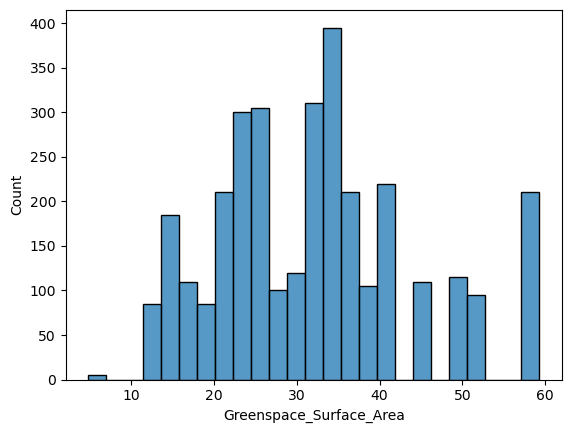

In [5]:
df.rename(columns={'Borough Green Space Surface': 'Greenspace_Surface_Area'}, inplace=True) 
sns.histplot(df['Greenspace_Surface_Area'])
plt.show();

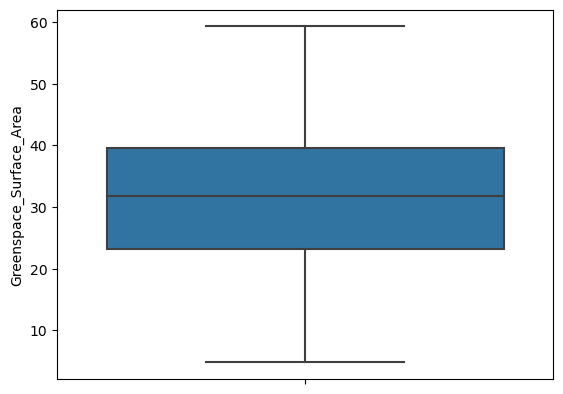

In [6]:
# Examine quantiles
sns.boxplot(y='Greenspace_Surface_Area', data=df);

In [7]:
#Create new categorical column for greenspace (Low, Medium, High)
df['Total_Greenspace'] = pd.cut(df['Greenspace_Surface_Area'], bins=3, labels=['Low', 'Medium', 'High'])
df.head()

,New ward code,Ward,Borough,Year,Life_Expectancy,Childhood_Obesity,Incapacity_Benefit,Unemployment,Crime,Deliberate_Fires,GCSE_points,Unauthorised_School_Absence,Dependent_children,Public_Transport_Access,Greespace_Access,Greenspace_Surface_Area,Total_Greenspace
0,E09000001,City of London,City of London,2009,84.329356,22.220000,3.333333,2.999195,18.389167,0.684932,346.80,0.24,17.14,7.723401,-6.478752,4.8,Low
1,E05000026,Abbey,Barking and Dagenham,2009,82.076112,21.700880,4.586610,8.325803,180.721564,1.908646,311.29,1.22,37.71,5.987356,-0.889538,33.6,Medium
2,E05000027,Alibon,Barking and Dagenham,2009,77.828392,25.974026,7.033561,9.857754,125.168618,1.099268,302.16,1.53,40.00,3.275530,-1.790968,33.6,Medium
3,E05000028,Becontree,Barking and Dagenham,2009,78.430683,22.448980,6.734643,9.405173,149.022537,0.967892,320.30,1.55,37.59,2.848544,-5.469666,33.6,Medium
4,E05000029,Chadwell Heath,Barking and Dagenham,2009,79.887841,23.795181,6.675432,8.567379,135.434080,1.850122,324.70,1.22,39.66,2.272302,1.977718,33.6,Medium


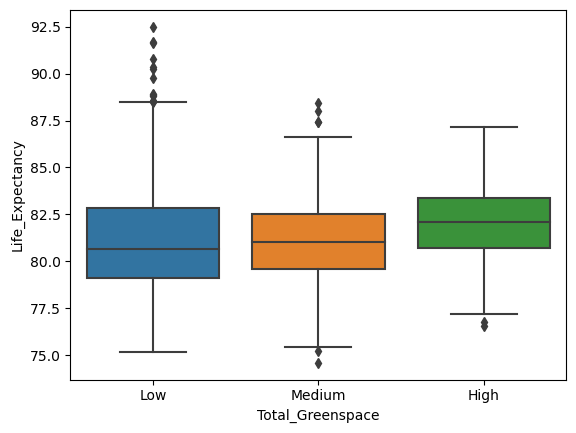

In [8]:
# Examine new categorical column for greenspace
sns.boxplot(x='Total_Greenspace', y='Life_Expectancy', data=df);

In [9]:
# Examine new categorical column for greenspace
df['Total_Greenspace'].value_counts()

Medium    1860
Low        775
High       640
Name: Total_Greenspace, dtype: int64

### 1b. Compute new greenspace feature column
Use median values for the Low, Median, High categories of total greenspace to create a new numerical measure of greenspace.

In [19]:
# Calculate median value for 'Borough Green Space Surface' for each grouping (Low/Med/High) of Total_Greenspace
# This will give me a numerical column for greenspace based on binned category median values

median_vals = df.groupby('Total_Greenspace', as_index=False)['Greenspace_Surface_Area'].median()
print(median_vals)

df['Binned_Median_Greenspace'] = df['Total_Greenspace'].map({'Low': median_vals.iloc[0][1], 'Medium': median_vals.iloc[1][1], 'High': median_vals.iloc[2][1]}).values.astype(float)

# Create another column with a simple numerical ranking for greenspace
df['Ranked_Greenspace'] = df['Total_Greenspace'].map({'Low': 0, 'Medium': 1, 'High': 2}).values.astype(float)

#print(df.Binned_Median_Greenspace.value_counts())
#print(df.Ranked_Greenspace.value_counts())

df.info()

  Total_Greenspace  Greenspace_Surface_Area
0              Low                     19.1
1           Medium                     31.7
2             High                     49.2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   New ward code                3275 non-null   object  
 1   Ward                         3275 non-null   object  
 2   Borough                      3275 non-null   object  
 3   Year                         3275 non-null   int64   
 4   Life_Expectancy              3275 non-null   float64 
 5   Childhood_Obesity            3275 non-null   float64 
 6   Incapacity_Benefit           3275 non-null   float64 
 7   Unemployment                 3275 non-null   float64 
 8   Crime                        3275 non-null   float64 
 9   Deliberate_Fires             3275 non-null   float64 
 10  GCSE

## 1c. Remove columns unnecessary for model
Since I a not looking at the change in time as a variable, I will remove the Year variable. <br>
The Ward variables are also redundant with Borough -- I will keep Borough only (to be used as a categorical variable) since that is the level of detail with which the data was collected. 

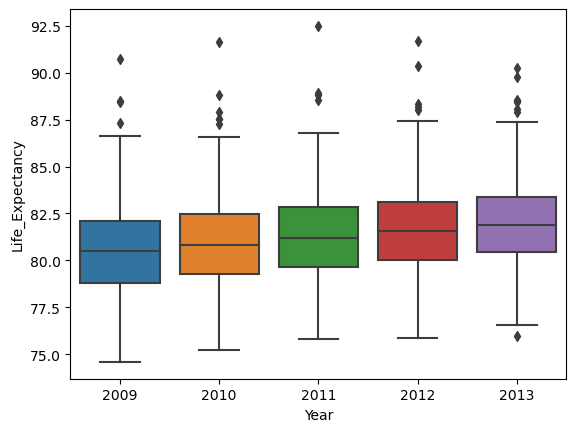

In [11]:
# Examine Life Expectancy Across Years
sns.boxplot(x='Year', y='Life_Expectancy', data=df);

In [36]:
# Drop unwanted columns
# Dropping Ward columns, Year
df_longevity = df.drop(columns=['New ward code', 'Ward', 'Year'])

In [37]:
df_longevity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Borough                      3275 non-null   object  
 1   Life_Expectancy              3275 non-null   float64 
 2   Childhood_Obesity            3275 non-null   float64 
 3   Incapacity_Benefit           3275 non-null   float64 
 4   Unemployment                 3275 non-null   float64 
 5   Crime                        3275 non-null   float64 
 6   Deliberate_Fires             3275 non-null   float64 
 7   GCSE_points                  3275 non-null   float64 
 8   Unauthorised_School_Absence  3275 non-null   float64 
 9   Dependent_children           3275 non-null   float64 
 10  Public_Transport_Access      3275 non-null   float64 
 11  Greespace_Access             3275 non-null   float64 
 12  Greenspace_Surface_Area      3275 non-null   float64 
 13  Tot

## 1. Train-test split data

In [38]:
df_longevity.shape

(3275, 15)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_longevity.drop(columns='Life_Expectancy'), 
                                                    df_longevity.Life_Expectancy, test_size=0.3, 
                                                    random_state=43)

In [40]:
X_train.shape, X_test.shape

((2292, 14), (983, 14))

In [41]:
y_train.shape, y_test.shape

((2292,), (983,))

In [42]:
#Check the `dtypes` attribute of `X_train` 
X_train.dtypes

Borough                          object
Childhood_Obesity               float64
Incapacity_Benefit              float64
Unemployment                    float64
Crime                           float64
Deliberate_Fires                float64
GCSE_points                     float64
Unauthorised_School_Absence     float64
Dependent_children              float64
Public_Transport_Access         float64
Greespace_Access                float64
Greenspace_Surface_Area         float64
Total_Greenspace               category
Binned_Median_Greenspace        float64
dtype: object

## 2. Scale numberical variables
Use StandardScalar to scale numeric variables to a standardized scale. The StandardScaler scales each feature to zero mean and unit variance.

In [43]:
# Drop categorical features
cat_cols = ['Borough', 'Total_Greenspace']
X_train_num = X_train.drop(columns=cat_cols)
X_test_num = X_test.drop(columns=cat_cols)

In [44]:
# Fit scaler to training data and transform training and test data
scaler = StandardScaler()
scaler.fit(X_train_num)
X_tr_scaled = scaler.transform(X_train_num)
X_te_scaled = scaler.transform(X_test_num)


In [45]:
X_tr_scaled.shape

(2292, 12)

In [46]:
X_te_scaled.shape

(983, 12)

In [49]:
# Create new scaled dataframes for X_train and X_test data
col_names = X_train.columns.drop(['Borough', 'Total_Greenspace'])

# Training data
X_tr_num = pd.DataFrame(X_tr_scaled, columns=col_names)

# Test data
X_te_num = pd.DataFrame(X_te_scaled, columns=col_names)


In [50]:
X_te_num.shape

(983, 12)

## 3. Create dummy variables for categorical data
Categorical columns are Borough and Total_Greenspace. <br>
I previously tried using pandas get_dummies for dummy encoding the data, but this produced a test dataset with fewer columns (due to the small size of the dataset). Therefore, I'm using sklearn's OneHotEncoder to deal with this problem.

In [51]:
# Get categorical features
cat_cols = ['Borough', 'Total_Greenspace']

X_train_cat = X_train[cat_cols]
X_test_cat = X_test[cat_cols]

In [52]:
X_train_cat.shape

(2292, 2)

In [53]:
X_test_cat.shape

(983, 2)

In [55]:
# Convert the Borough and Total Greenspace columns to a one hot encoded Data Frame on both training and test data

enc = OneHotEncoder(handle_unknown='ignore')

# Fit and transform 
X_train_transformed = enc.fit_transform(X_train_cat)
X_test_transformed = enc.transform(X_test_cat)

# Convert back to data frame
X_train_ohe = pd.DataFrame(X_train_transformed.toarray(), columns = enc.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_transformed.toarray(), columns = enc.get_feature_names_out())

# Concat with numerical scaled data
X_train_complete = pd.concat([X_tr_num, X_train_ohe], axis=1)
X_test_complete = pd.concat([X_te_num, X_test_ohe], axis=1)



In [56]:
X_train_complete.shape

(2292, 48)

In [57]:
X_test_complete.shape

(983, 48)

In [59]:
#X_train_complete.info()

I now have an all numeric dataset that is ready for modeling. It contains scaled numerical variables, as well as two categorical variables (Borough and Total_Greenspace) that have been one-hot-encoded for modeling. <br>
<br>